# 라이브러리 임포트 및 함수 정의

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
import warnings
from matplotlib import font_manager, rc
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors

font_path = "C:/Windows/Fonts/NGULIM.TTF"
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)

def get_outlier(df=None, column=None, weight=1.5):
  # target 값과 상관관계가 높은 열을 우선적으로 진행
  quantile_25 = np.percentile(df[column].values, 25)
  quantile_75 = np.percentile(df[column].values, 75)

  IQR = quantile_75 - quantile_25
  IQR_weight = IQR*weight
  
  lowest = quantile_25 - IQR_weight
  highest = quantile_75 + IQR_weight
  
  outlier_idx = df[column][ (df[column] < lowest) | (df[column] > highest) ].index
  return outlier_idx

### 여러개의 클러스터링 갯수를 List로 입력 받아 각각의 실루엣 계수를 면적으로 시각화한 함수 작성
def visualize_silhouette(cluster_lists, X_features): 
    
    from sklearn.datasets import make_blobs
    from sklearn.cluster import KMeans
    from sklearn.metrics import silhouette_samples, silhouette_score

    import matplotlib.pyplot as plt
    import matplotlib.cm as cm
    import math
    
    # 입력값으로 클러스터링 갯수들을 리스트로 받아서, 각 갯수별로 클러스터링을 적용하고 실루엣 개수를 구함
    n_cols = len(cluster_lists)
    
    # plt.subplots()으로 리스트에 기재된 클러스터링 수만큼의 sub figures를 가지는 axs 생성 
    fig, axs = plt.subplots(figsize=(4*n_cols, 4), nrows=1, ncols=n_cols)
    
    # 리스트에 기재된 클러스터링 갯수들을 차례로 iteration 수행하면서 실루엣 개수 시각화
    for ind, n_cluster in enumerate(cluster_lists):
        
        # KMeans 클러스터링 수행하고, 실루엣 스코어와 개별 데이터의 실루엣 값 계산. 
        clusterer = KMeans(n_clusters = n_cluster, max_iter=500, random_state=0)
        cluster_labels = clusterer.fit_predict(X_features)
        
        sil_avg = silhouette_score(X_features, cluster_labels)
        sil_values = silhouette_samples(X_features, cluster_labels)
        
        y_lower = 10
        axs[ind].set_title('Number of Cluster : '+ str(n_cluster)+'\n' \
                          'Silhouette Score :' + str(round(sil_avg,3)) )
        axs[ind].set_xlabel("The silhouette coefficient values")
        axs[ind].set_ylabel("Cluster label")
        axs[ind].set_xlim([-0.1, 1])
        axs[ind].set_ylim([0, len(X_features) + (n_cluster + 1) * 10])
        axs[ind].set_yticks([])  # Clear the yaxis labels / ticks
        axs[ind].set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
        
        # 클러스터링 갯수별로 fill_betweenx( )형태의 막대 그래프 표현. 
        for i in range(n_cluster):
            ith_cluster_sil_values = sil_values[cluster_labels==i]
            ith_cluster_sil_values.sort()
            
            size_cluster_i = ith_cluster_sil_values.shape[0]
            y_upper = y_lower + size_cluster_i
            
            color = cm.nipy_spectral(float(i) / n_cluster)
            axs[ind].fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_sil_values, \
                                facecolor=color, edgecolor=color, alpha=0.7)
            axs[ind].text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
            y_lower = y_upper + 10
            
        axs[ind].axvline(x=sil_avg, color="red", linestyle="--")

# 데이터 확인

In [2]:
data = pd.read_csv('C:/Users/hyunj/Desktop/데이터마이닝 코드/국민건강보험공단_건강검진정보_20211229.csv', encoding='CP949')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 31 columns):
 #   Column        Non-Null Count    Dtype  
---  ------        --------------    -----  
 0   기준년도          1000000 non-null  int64  
 1   가입자 일련번호      1000000 non-null  int64  
 2   시도코드          1000000 non-null  int64  
 3   성별코드          1000000 non-null  int64  
 4   연령대 코드(5세단위)  1000000 non-null  int64  
 5   신장(5Cm단위)     1000000 non-null  int64  
 6   체중(5Kg 단위)    1000000 non-null  int64  
 7   허리둘레          999892 non-null   float64
 8   시력(좌)         999743 non-null   float64
 9   시력(우)         999748 non-null   float64
 10  청력(좌)         999778 non-null   float64
 11  청력(우)         999770 non-null   float64
 12  수축기 혈압        992468 non-null   float64
 13  이완기 혈압        992466 non-null   float64
 14  식전혈당(공복혈당)    992398 non-null   float64
 15  총 콜레스테롤       402306 non-null   float64
 16  트리글리세라이드      402322 non-null   float64
 17  HDL 콜레스테롤     402315 non-nul

특정 Feautre에 NULL 값이 있는 것을 확인

# 데이터 전처리

* BMI 계산

In [3]:
# BMI 계산
for i in tqdm(range(len(data)), desc = 'BMI 계산중') :
    data.loc[i, 'BMI'] = round(data.loc[i, '체중(5Kg 단위)'] / data.loc[i, '신장(5Cm단위)'] / data.loc[i, '신장(5Cm단위)'] * 10000, 2)

BMI 계산중: 100%|██████████████████████████████████████████████████████████| 1000000/1000000 [02:44<00:00, 6096.51it/s]


* Feature Selection

In [4]:
data = data.drop(['기준년도', '가입자 일련번호', '시도코드', '신장(5Cm단위)', '체중(5Kg 단위)',
                     '허리둘레', '시력(좌)', '시력(우)', '청력(좌)', '청력(우)',
                     '구강검진 수검여부', '치아우식증유무', '치석', '데이터 공개일자'], axis = 1)

data.dropna(axis=0, inplace=True)
data.reset_index()

,index,성별코드,연령대 코드(5세단위),수축기 혈압,이완기 혈압,식전혈당(공복혈당),총 콜레스테롤,트리글리세라이드,HDL 콜레스테롤,LDL 콜레스테롤,혈색소,요단백,혈청크레아티닌,(혈청지오티)AST,(혈청지오티)ALT,감마 지티피,흡연상태,음주여부,BMI
0,0,1,9,127.0,79.0,90.0,188.0,58.0,58.0,118.0,15.0,1.0,1.1,21.0,27.0,21.0,1.0,0.0,22.04
1,4,2,12,144.0,89.0,110.0,220.0,171.0,53.0,133.0,12.4,1.0,0.7,18.0,17.0,14.0,1.0,0.0,20.81
2,5,1,9,114.0,72.0,86.0,234.0,183.0,50.0,147.0,16.4,1.0,1.1,25.0,32.0,26.0,3.0,1.0,24.84
3,6,1,9,112.0,73.0,250.0,119.0,265.0,26.0,40.0,15.7,1.0,0.7,18.0,20.0,35.0,3.0,1.0,29.38
4,8,2,17,136.0,65.0,104.0,177.0,61.0,63.0,101.0,13.3,1.0,0.7,42.0,48.0,39.0,1.0,0.0,22.22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
392209,999992,1,13,120.0,74.0,98.0,142.0,121.0,38.0,79.0,15.1,1.0,0.8,66.0,58.0,36.0,2.0,1.0,29.39
392210,999995,2,13,132.0,78.0,124.0,178.0,301.0,43.0,75.0,13.6,1.0,0.6,21.0,25.0,18.0,1.0,0.0,26.16
392211,999996,2,12,100.0,64.0,98.0,288.0,93.0,71.0,198.0,14.0,1.0,0.8,21.0,14.0,19.0,1.0,1.0,21.48
392212,999998,2,9,137.0,82.0,111.0,208.0,113.0,59.0,126.0,11.9,1.0,1.0,25.0,29.0,13.0,1.0,0.0,27.34


* 이상치 제거하기 전의 남자 & 여자 데이터 Box Plot 확인

C:\Users\hyunj\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


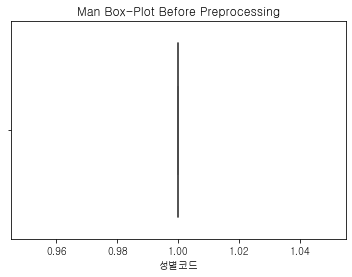

C:\Users\hyunj\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


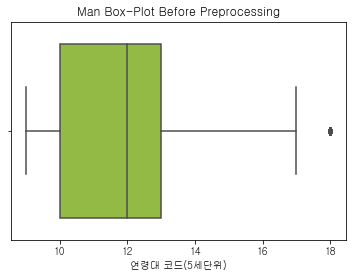

C:\Users\hyunj\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


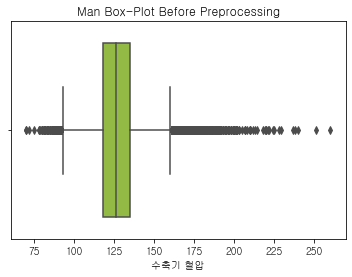

C:\Users\hyunj\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


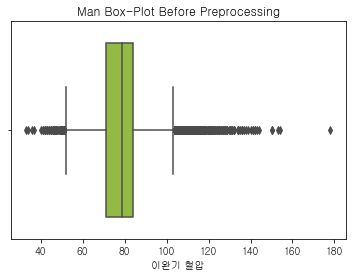

C:\Users\hyunj\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


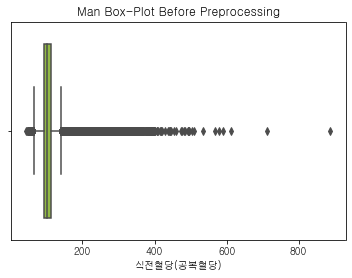

C:\Users\hyunj\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


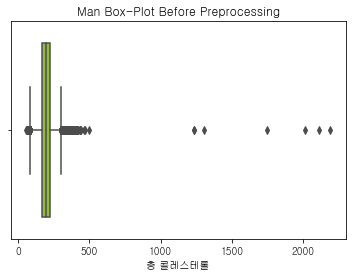

C:\Users\hyunj\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


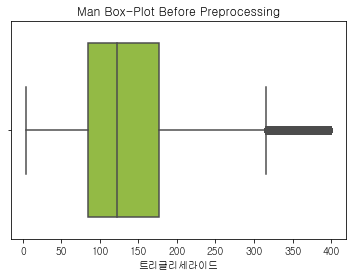

C:\Users\hyunj\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


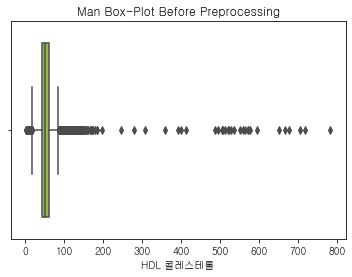

C:\Users\hyunj\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


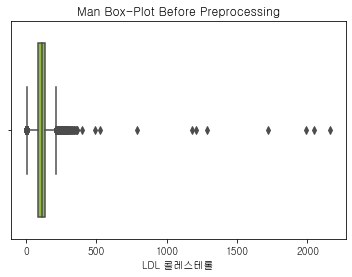

C:\Users\hyunj\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


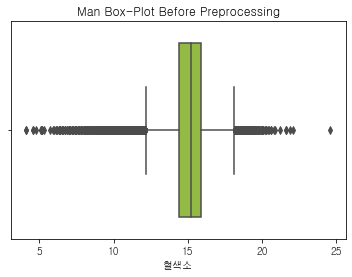

C:\Users\hyunj\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


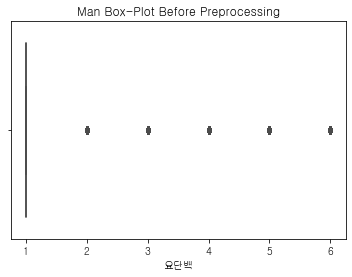

C:\Users\hyunj\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


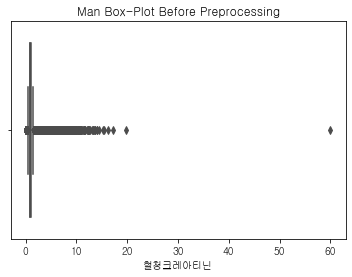

C:\Users\hyunj\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


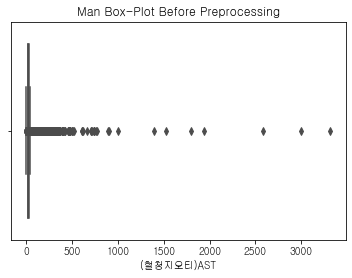

C:\Users\hyunj\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


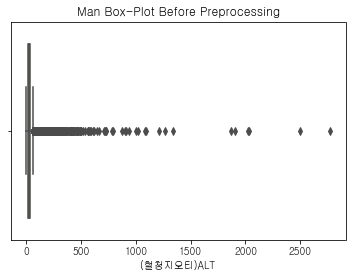

C:\Users\hyunj\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


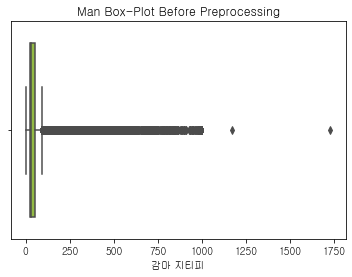

C:\Users\hyunj\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


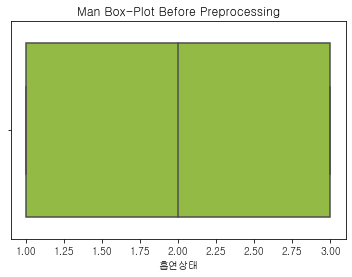

C:\Users\hyunj\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


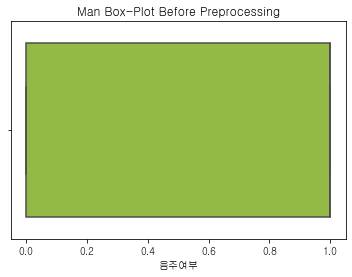

C:\Users\hyunj\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


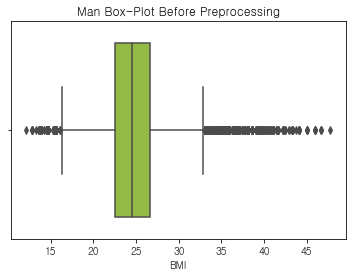

C:\Users\hyunj\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


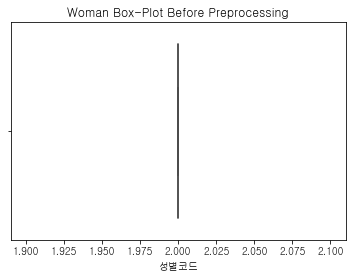

C:\Users\hyunj\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


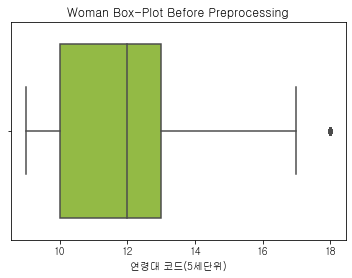

C:\Users\hyunj\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


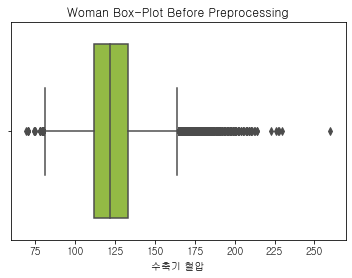

C:\Users\hyunj\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


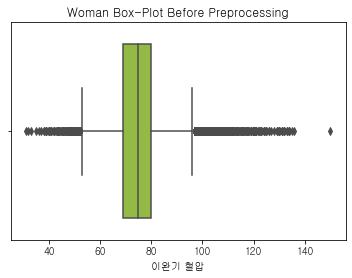

C:\Users\hyunj\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


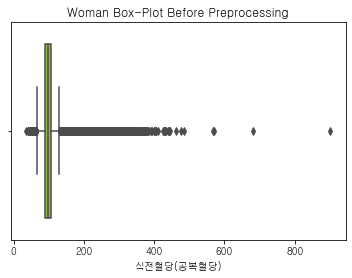

C:\Users\hyunj\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


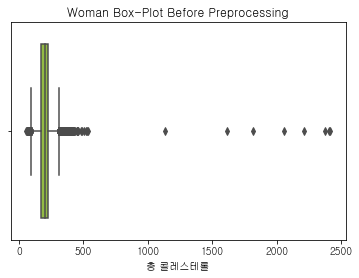

C:\Users\hyunj\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


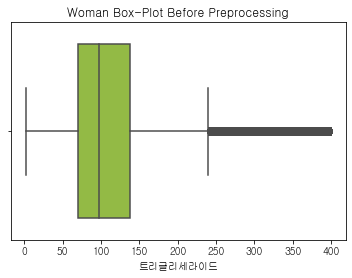

C:\Users\hyunj\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


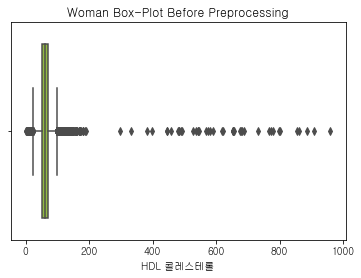

C:\Users\hyunj\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


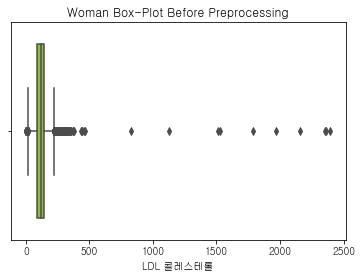

C:\Users\hyunj\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


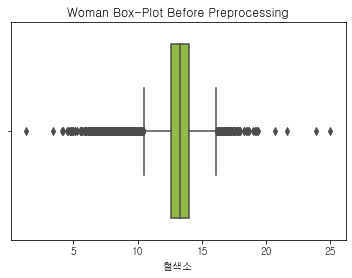

C:\Users\hyunj\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


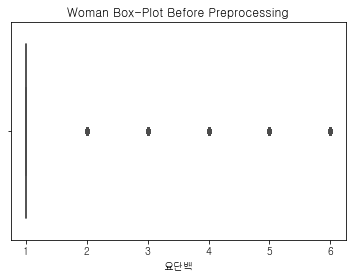

C:\Users\hyunj\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


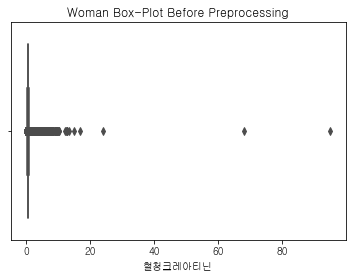

C:\Users\hyunj\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


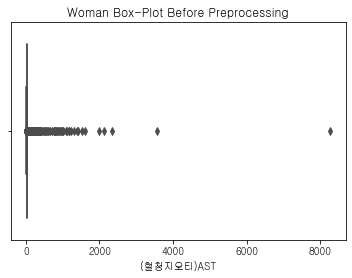

C:\Users\hyunj\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


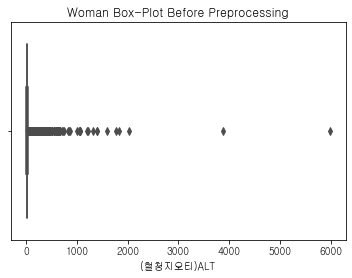

C:\Users\hyunj\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


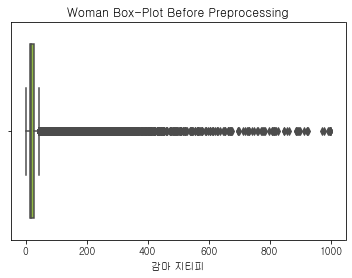

C:\Users\hyunj\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


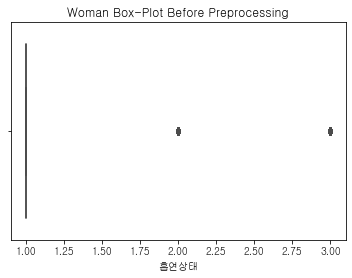

C:\Users\hyunj\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


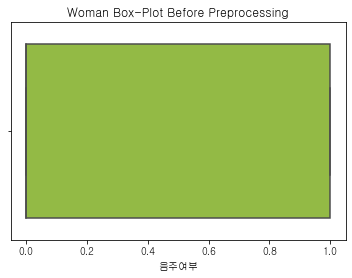

C:\Users\hyunj\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


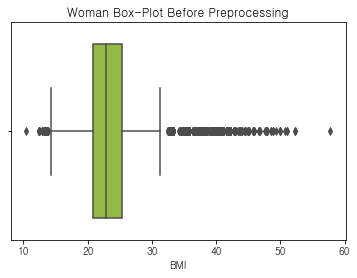

In [5]:
data_man = data.loc[data['성별코드'] == 1]
data_woman = data.loc[data['성별코드'] == 2]
data_man.reset_index(inplace = True, drop=True)
data_woman.reset_index()
columns = list(data_man.columns)

# 남자 Box Plot 확인
for i in data_man.columns:
    sns.boxplot(data_man[i],color = 'yellowgreen')   
    plt.xlabel(i)
    plt.title('Man Box-Plot Before Preprocessing')
    plt.show()
  
# 여자 Box Plot 확인
for i in data_woman.columns:
    sns.boxplot(data_woman[i],color = 'yellowgreen')   
    plt.xlabel(i)
    plt.title('Woman Box-Plot Before Preprocessing')
    plt.show()

* 이상치 제거 후의 남자 & 여자 데이터 Box Plot 확인

C:\Users\hyunj\AppData\Local\Temp\ipykernel_31452\3754723042.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_man.drop(outlier_idx, axis=0, inplace=True)
C:\Users\hyunj\AppData\Local\Temp\ipykernel_31452\3754723042.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_woman.drop(outlier_idx, axis=0, inplace=True)
C:\Users\hyunj\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpreta

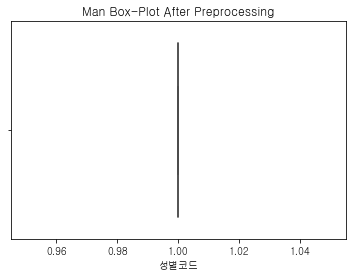

C:\Users\hyunj\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


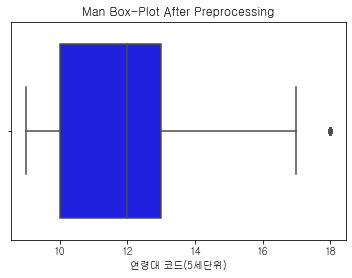

C:\Users\hyunj\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


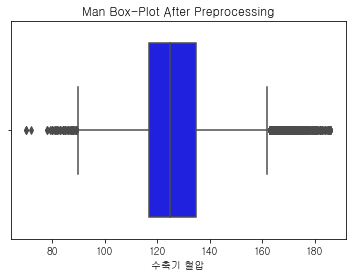

C:\Users\hyunj\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


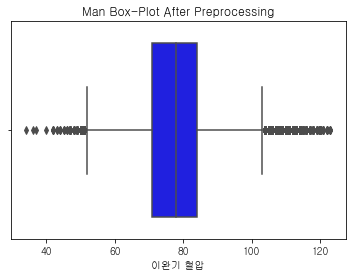

C:\Users\hyunj\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


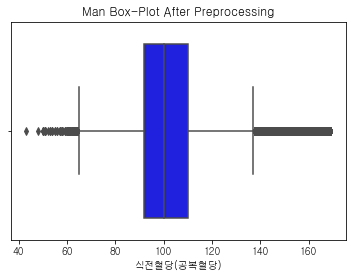

C:\Users\hyunj\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


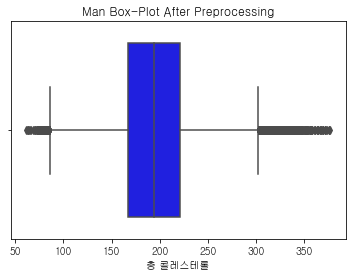

C:\Users\hyunj\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


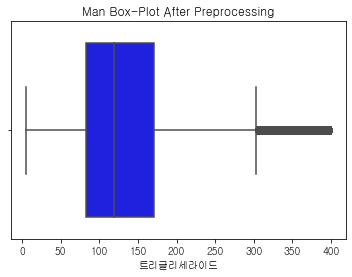

C:\Users\hyunj\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


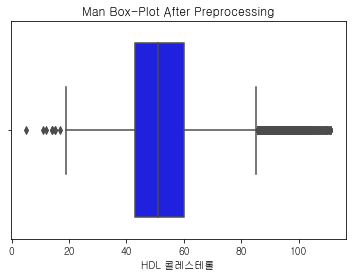

C:\Users\hyunj\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


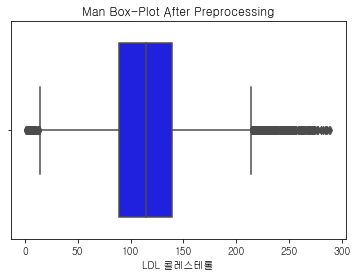

C:\Users\hyunj\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


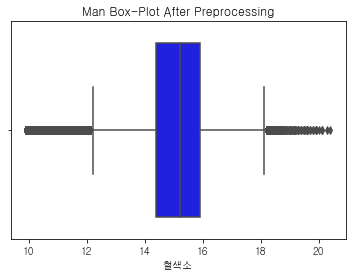

C:\Users\hyunj\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


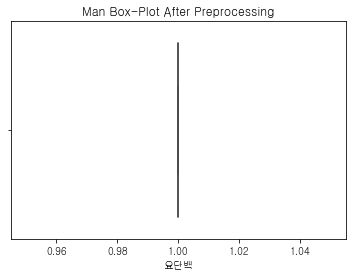

C:\Users\hyunj\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


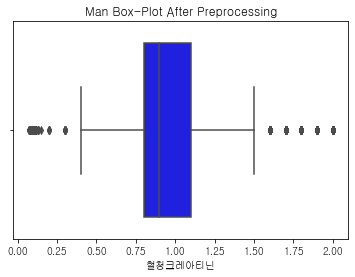

C:\Users\hyunj\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


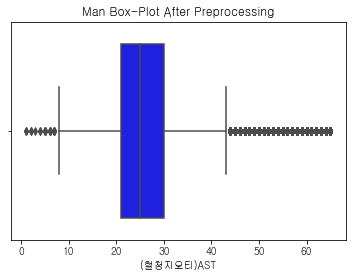

C:\Users\hyunj\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


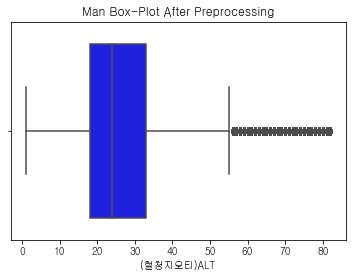

C:\Users\hyunj\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


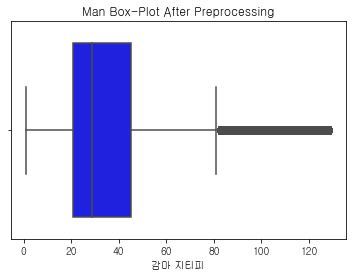

C:\Users\hyunj\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


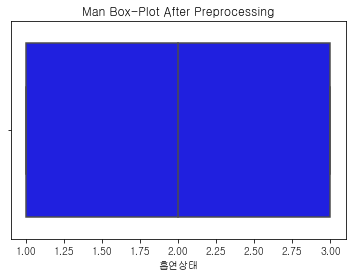

C:\Users\hyunj\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


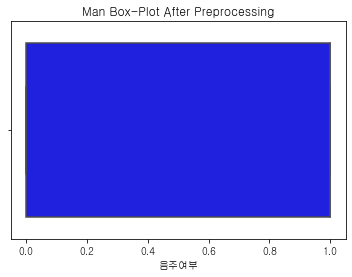

C:\Users\hyunj\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


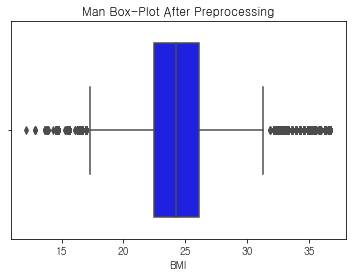

C:\Users\hyunj\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


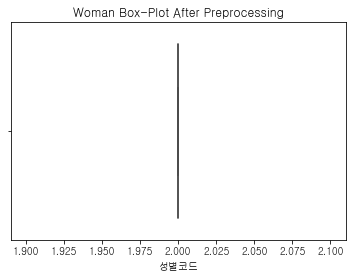

C:\Users\hyunj\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


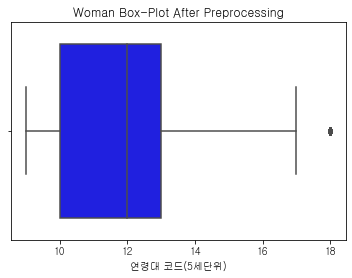

C:\Users\hyunj\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


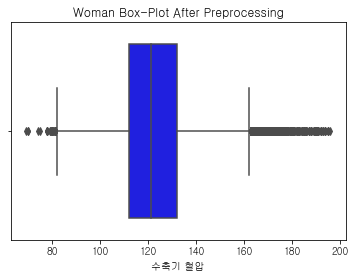

C:\Users\hyunj\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


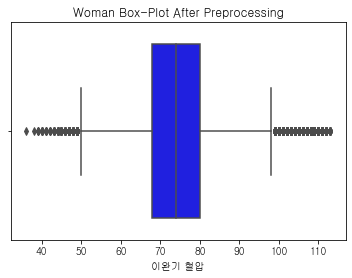

C:\Users\hyunj\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


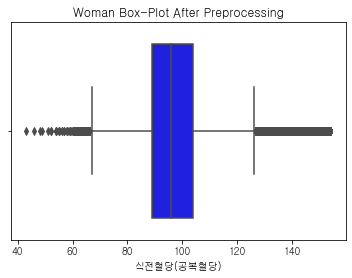

C:\Users\hyunj\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


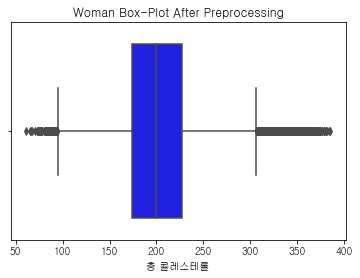

C:\Users\hyunj\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


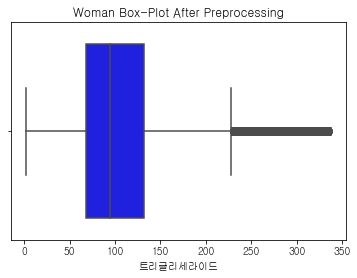

C:\Users\hyunj\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


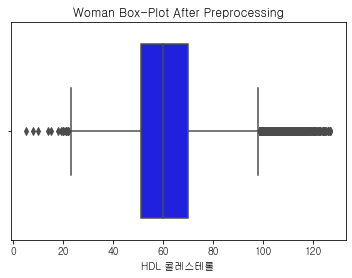

C:\Users\hyunj\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


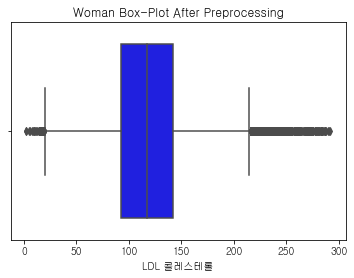

C:\Users\hyunj\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


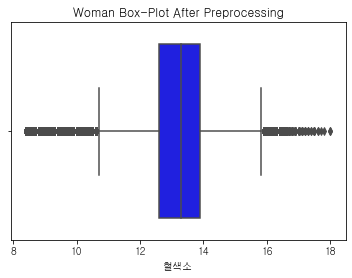

C:\Users\hyunj\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


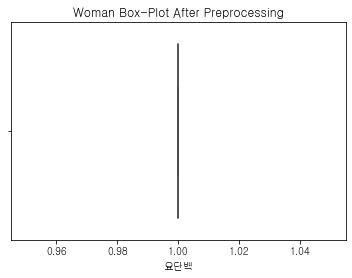

C:\Users\hyunj\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


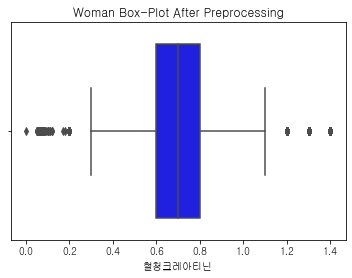

C:\Users\hyunj\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


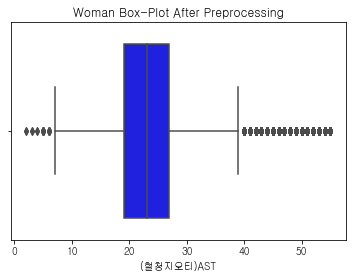

C:\Users\hyunj\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


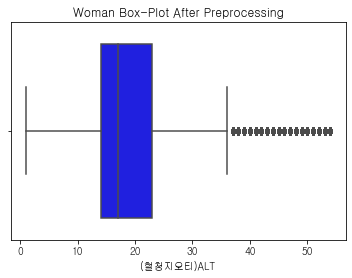

C:\Users\hyunj\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


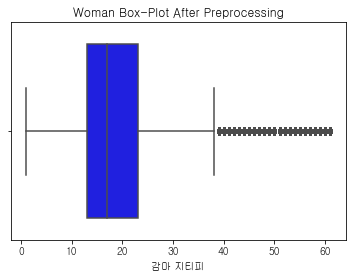

C:\Users\hyunj\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


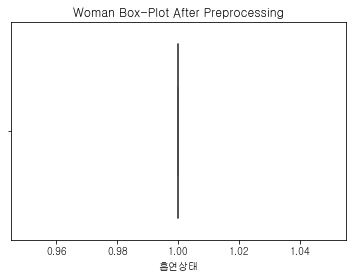

C:\Users\hyunj\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


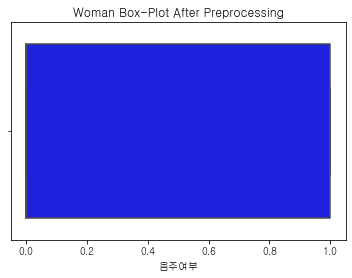

C:\Users\hyunj\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


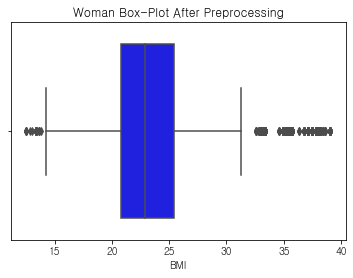

In [6]:
# 이상치 전처리 
for column in columns : 
    outlier_idx = get_outlier(df=data_man, column=column, weight=3)
    data_man.drop(outlier_idx, axis=0, inplace=True)
    
for column in columns : 
    outlier_idx = get_outlier(df=data_woman, column=column, weight=3)
    data_woman.drop(outlier_idx, axis=0, inplace=True)
    
for i in data_man.columns:
    sns.boxplot(data_man[i],color = 'blue')   
    plt.xlabel(i)
    plt.title('Man Box-Plot After Preprocessing')
    plt.show()

for i in data_woman.columns:
    sns.boxplot(data_woman[i],color = 'blue')   
    plt.xlabel(i)
    plt.title('Woman Box-Plot After Preprocessing')
    plt.show()

* 이상치 제거 (논문에 근거하여 IQR 범위의 3배로 지정)

In [7]:
columns = list(data.columns)
for column in columns : 
    outlier_idx = get_outlier(df=data, column=column, weight=3)
    data.drop(outlier_idx, axis=0, inplace=True)
    
data

,성별코드,연령대 코드(5세단위),수축기 혈압,이완기 혈압,식전혈당(공복혈당),총 콜레스테롤,트리글리세라이드,HDL 콜레스테롤,LDL 콜레스테롤,혈색소,요단백,혈청크레아티닌,(혈청지오티)AST,(혈청지오티)ALT,감마 지티피,흡연상태,음주여부,BMI
0,1,9,127.0,79.0,90.0,188.0,58.0,58.0,118.0,15.0,1.0,1.1,21.0,27.0,21.0,1.0,0.0,22.04
4,2,12,144.0,89.0,110.0,220.0,171.0,53.0,133.0,12.4,1.0,0.7,18.0,17.0,14.0,1.0,0.0,20.81
5,1,9,114.0,72.0,86.0,234.0,183.0,50.0,147.0,16.4,1.0,1.1,25.0,32.0,26.0,3.0,1.0,24.84
8,2,17,136.0,65.0,104.0,177.0,61.0,63.0,101.0,13.3,1.0,0.7,42.0,48.0,39.0,1.0,0.0,22.22
10,2,16,128.0,70.0,92.0,152.0,175.0,32.0,85.0,13.0,1.0,0.7,24.0,22.0,12.0,1.0,0.0,22.89
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999991,2,11,135.0,86.0,99.0,174.0,82.0,43.0,115.0,15.3,1.0,0.7,24.0,24.0,16.0,1.0,1.0,27.06
999995,2,13,132.0,78.0,124.0,178.0,301.0,43.0,75.0,13.6,1.0,0.6,21.0,25.0,18.0,1.0,0.0,26.16
999996,2,12,100.0,64.0,98.0,288.0,93.0,71.0,198.0,14.0,1.0,0.8,21.0,14.0,19.0,1.0,1.0,21.48
999998,2,9,137.0,82.0,111.0,208.0,113.0,59.0,126.0,11.9,1.0,1.0,25.0,29.0,13.0,1.0,0.0,27.34


# 데이터 저장

In [8]:
# 이상치 제거된 CSV 파일 저장
data.to_csv('C:/Users/hyunj/Desktop/데이터마이닝 코드/New_After_Preprocessing.csv', encoding='CP949', index = False)

# 전처리한 데이터 중 50대 남자 분포 확인

* 데이터프레임 단위로 확인

In [9]:
data = pd.read_csv('C:/Users/hyunj/Desktop/데이터마이닝 코드/New_After_Preprocessing.csv', encoding='CP949')
data_man = data.loc[data['성별코드'] == 1]

data_man = data_man.loc[(data_man['연령대 코드(5세단위)'] == 11) | (data_man['연령대 코드(5세단위)'] == 12)]
data_man.drop('성별코드', axis =1, inplace=True)
data_man.drop('연령대 코드(5세단위)', axis = 1, inplace = True)
data_man.drop('요단백', axis = 1, inplace = True)
data_man.reset_index(inplace = True, drop=True)
    
data_man

,수축기 혈압,이완기 혈압,식전혈당(공복혈당),총 콜레스테롤,트리글리세라이드,HDL 콜레스테롤,LDL 콜레스테롤,혈색소,혈청크레아티닌,(혈청지오티)AST,(혈청지오티)ALT,감마 지티피,흡연상태,음주여부,BMI
0,138.0,88.0,94.0,223.0,328.0,46.0,111.0,16.6,1.0,29.0,54.0,24.0,1.0,1.0,25.39
1,130.0,80.0,102.0,158.0,193.0,41.0,79.0,14.8,0.7,21.0,19.0,20.0,1.0,0.0,24.22
2,165.0,100.0,97.0,192.0,69.0,79.0,99.0,15.4,0.9,24.0,10.0,46.0,3.0,1.0,27.68
3,140.0,80.0,93.0,256.0,148.0,46.0,180.0,16.0,1.1,20.0,22.0,23.0,3.0,1.0,25.95
4,136.0,86.0,98.0,209.0,100.0,39.0,150.0,14.0,1.0,28.0,32.0,19.0,2.0,1.0,23.88
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33692,125.0,70.0,116.0,184.0,114.0,49.0,112.0,16.9,1.0,20.0,10.0,21.0,3.0,1.0,19.59
33693,108.0,76.0,107.0,214.0,97.0,50.0,144.0,15.5,0.7,24.0,24.0,52.0,1.0,1.0,23.88
33694,116.0,72.0,103.0,276.0,75.0,75.0,180.0,13.4,0.9,40.0,44.0,25.0,1.0,1.0,22.49
33695,120.0,70.0,110.0,224.0,73.0,65.0,144.0,15.1,0.9,24.0,14.0,35.0,2.0,1.0,21.22


* 남자의 히스토그램 확인

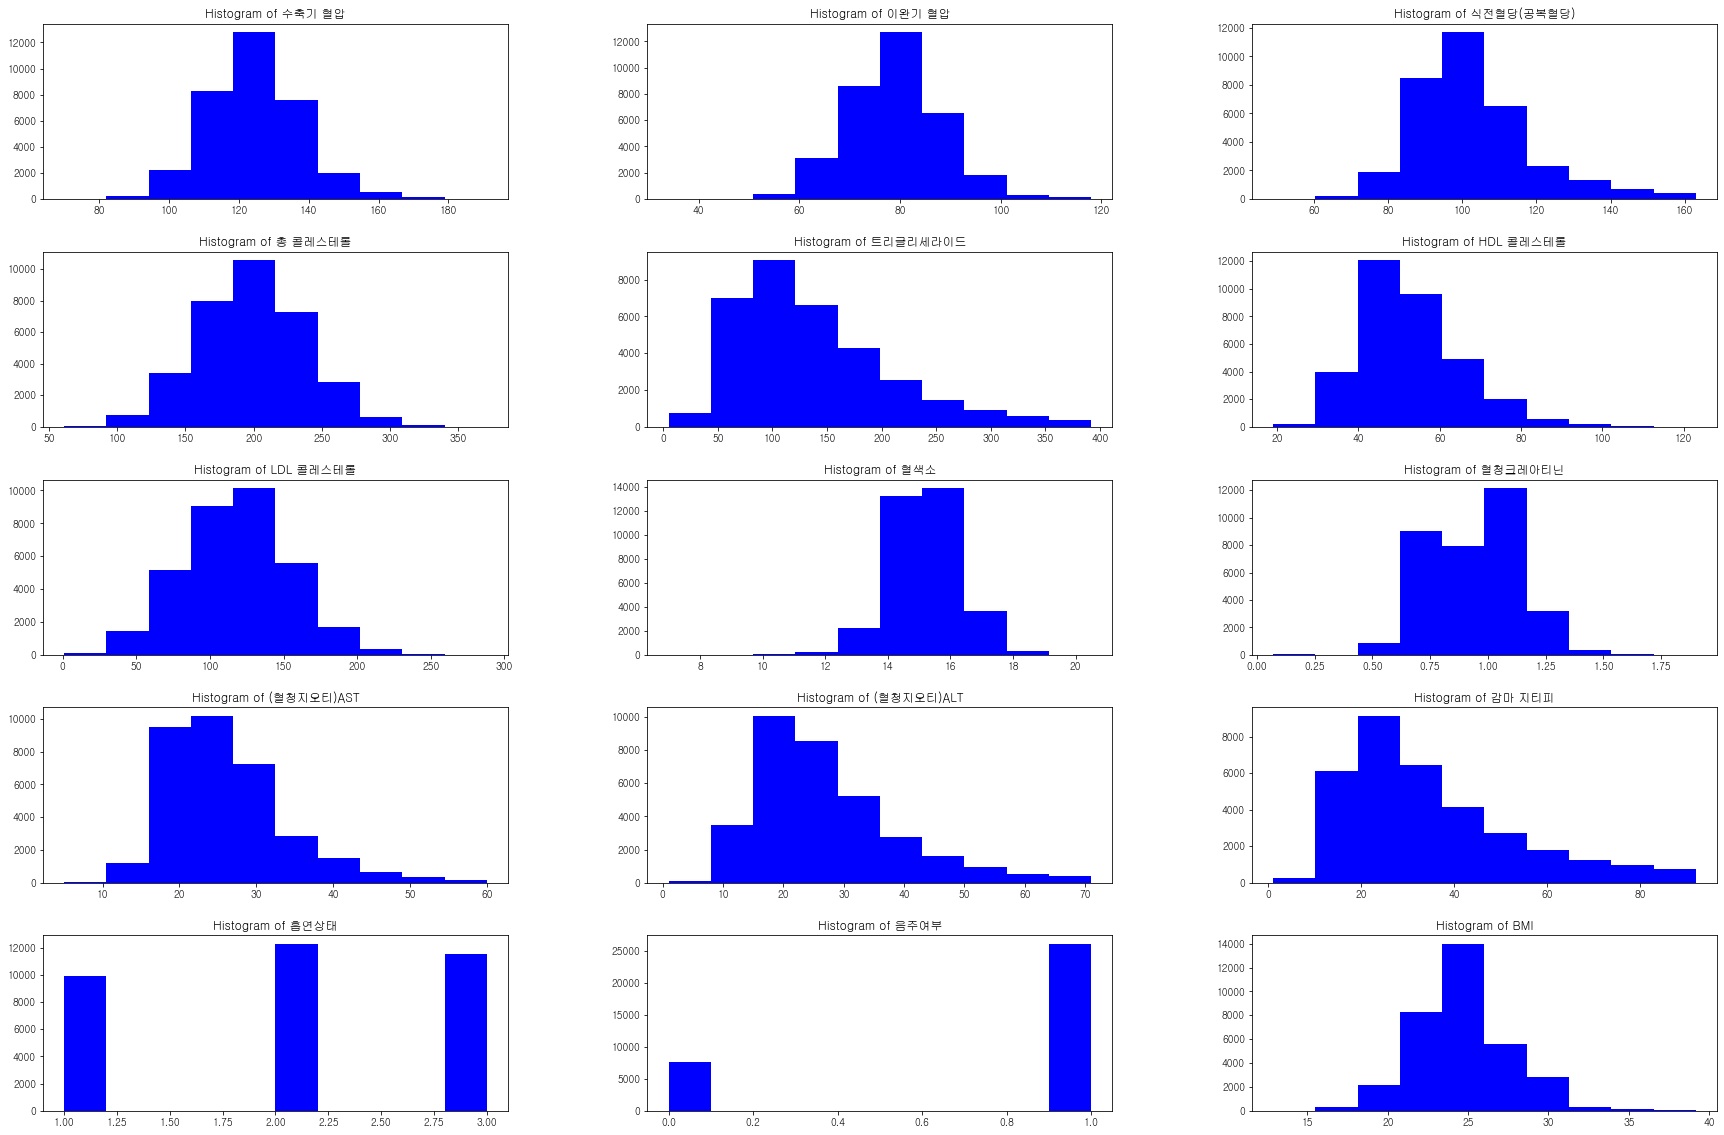

In [10]:
columns = list(data_man.columns)
i = 1 
plt.figure(figsize=(30, 20))
for feature in columns:
    plt.subplot(5, 3, i)
    plt.subplots_adjust(hspace=0.3, wspace=0.3)
    plt.title("Histogram of {}".format(feature))
    plt.hist(data_man[feature], color='blue')
    i+=1

plt.show()

* Log Transform 후 분포 확인

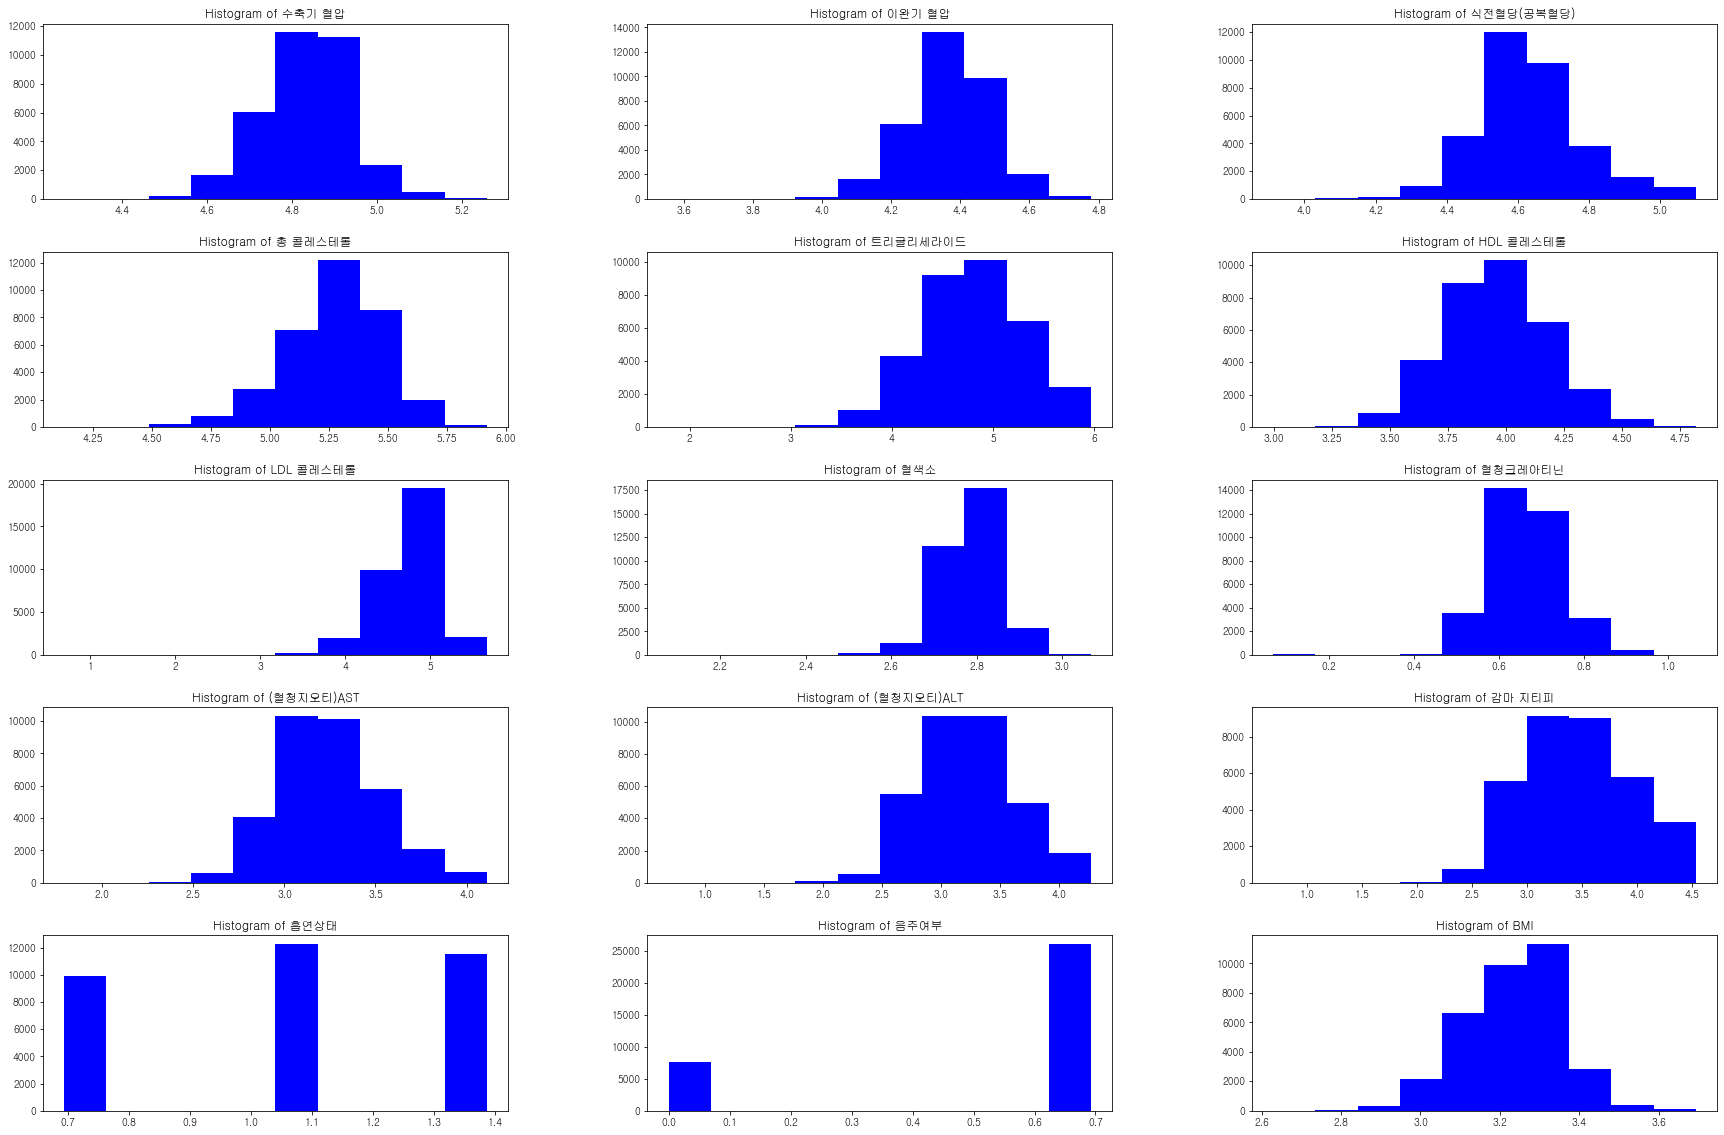

In [11]:
for feature in columns :
    data_man[feature] = np.log1p(data_man[feature])
    
i = 1        
plt.figure(figsize=(30, 20))
for feature in columns:
    plt.subplot(5, 3, i)
    plt.subplots_adjust(hspace=0.3, wspace=0.3)
    plt.title("Histogram of {}".format(feature))
    plt.hist(data_man[feature], color='blue')
    i+=1

plt.show()